###Constants

$C_0 = 0.05$</br>
$m_l = -81.1$</br>
$m_s = -478$</br>
$c_p = 820$</br>
$ρ = 7000$</br>
$L_f = 276000$</br>
$T_f = 1538$</br>
$T_∞ = 1540$</br>
$T_0 = 1510$</br>
$k_0 = 0.17$</br>
$Le = 300$</br>

$Ste = c_p(T_∞-T_0)/L_f$</br>
$θ_f = (T_f-T_0)/(T_∞-T_0)$

###Conditions

Domain $\epsilon \in [0,ϵ^*]$</br>
$C_s = k_0C_l^*$</br>
PDE1: $\frac{∂\theta_s}{∂\tau} = \frac{∂^2\theta_s}{∂\epsilon^2}$</br>
Domain $\epsilon \in [ϵ^*,1]$</br>
PDE2: $\frac{∂\theta_l}{∂\tau} = \frac{∂^2\theta_l}{∂\epsilon^2}$</br>
PDE3: $\frac{∂C_l}{∂\tau} = \frac{1}{Le}\frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface ($ϵ=ϵ^*$)</br>
PDE4: $\frac{1}{Ste}\frac{∂\epsilon^*}{∂\tau} = \frac{∂\theta_s}{∂\epsilon}-\frac{∂\theta_l}{∂\epsilon}$</br>
PDE5: $\frac{-1}{Le}\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)\frac{dϵ^*}{dτ}$</br>

5 PDEs with 5 Variables [$θ_s(x,t)$, $θ_l(x,t)$, $C_s(x,t)$, $C_l(x,t)$, $ϵ^*(t)$]</br>
Model the 5 variables using 3 neural networks and optimise the NN parameters</br>

Initial ($\tau = 0$)</br>
$θ_l=1$ ; $C_l=C_0$ ; $ϵ^*=0$</br>
Interface ($ϵ=ϵ^*$)</br>
$θ_s=θ_l=θ^*$</br>
$C_l^* = (T_0-T_∞)(θ_f-θ^*)/m_l$</br>
Left BC ($ϵ=0$)</br>
$θ_s=0$

##Code

In [ ]:
import tensorflow as tf
import numpy as np
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0, phi = 0.05*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.17*a, 0.1159*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
def C_(u_):
  return (T0-Ti)*(uf-u_)/ml # concentration of liquid at interface (Cl*) given interface temp

###Evaluating PDEs

In [ ]:
def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - u2_xx

def f3(c_t, c_xx): # calculates PDE3 value given c's derivatives
  return c_t - (c_xx/Le)

def f4(s_t, u1_x, u2_x): # calculates PDE4 value
  return (s_t/Ste) - u1_x + u2_x

def f5(c_x, cstar, s_t): # calculates PDE5 value
  return (cstar*(1-k0)*s_t)+(c_x/Le)

###Analytical Solutions

In [ ]:
def u1_anal(t,x): # calculates u1 value from its analytical solution
  return ustar*tf.math.erf(x/(2*(t**0.5)))/tf.math.erf(phi)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return 1-((1-ustar)*tf.math.erfc(x/(2*(t**0.5)))/tf.math.erfc(phi))

c1_anal = k0*C_(ustar) # analytical value of Cs

def c2_anal(t,x): # calculates c2 value from its analytical solution
  return C0 + ((C_(ustar)-C0)*tf.math.erfc((x*(Le**0.5))/(2*(t**0.5)))/tf.math.erfc(phi*(Le**0.5)))

def s_anal(t): # calculates s value from its analytical solution
  return 2*phi*(t**0.5)

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

def c_anal(t,x): # analytical value of c given x and t
  return tf.where(tf.math.greater(s_anal(t),x),c1_anal,c2_anal(t,x))

###Training Data

In [ ]:
Nm = 200 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm = tf.random.uniform((Nm,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xm = tf.random.uniform((Nm,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points

###Optional Data

In [ ]:
Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xb = tf.ones((Nb,1))*xmin # xmin repeated Nb times
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

###Modelling Variables

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for c1 and c2
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

###Compute gradients to return PDE values

In [ ]:
def get_f(umodel, smodel, cmodel, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    c = cmodel(tf.concat([t, x], axis=1)) # c1 and c2 as functions of t and x
    c1, c2 = c[:, 0:1], c[:, 1:2]
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    cb = cmodel(tf.concat([t, s], axis=1))[:, 1:2]
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

###Calculating loss

In [ ]:
def loss_fxn(umodel, smodel, cmodel, mea, um, cm, xc, times, e): # compute loss given model and data

    pum = umodel(mea) # Temperature prediction on measurement data
    pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
    pcm = cmodel(mea) # Concentration prediction on measurement data
    pc1m, pc2m =  pcm[:, 0:1], pcm[:, 1:2]
    psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
    pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
    pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
    Lm1 = tf.reduce_mean(tf.square(um - pum))*128
    Lm2 = tf.reduce_mean(tf.square(cm - pcm))*128
    Lm = Lm1 + Lm2

    init = tf.constant(0,shape=(1,1),dtype=DTYPE)
    ti = tf.zeros(shape=xc.shape, dtype=DTYPE)
    init2 = tf.concat([ti, xc], axis=1)
    pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
    pc2i = cmodel(init2)[:, 1:2] # predicted initial conc of liquid
    Li1 = tf.squeeze(tf.square(smodel(init)))*25600
    Li2 = tf.reduce_mean(tf.square(pc2i-C0))*100
    Li3 = tf.reduce_mean(tf.square(pu2i-a))*100
    Li = Li1 + Li2 + Li3

    tot_loss = Lm + Li
    sum_loss = tf.zeros(shape=(), dtype=DTYPE)
    loss_list = [tf.zeros(shape=(), dtype=DTYPE)]*14
    loss_list[4], loss_list[5], loss_list[6] = Li1, Li2, Li3
    loss_list[-2], loss_list[-1] = Lm1, Lm2

    for t in times:

      w = tf.math.exp(-e*sum_loss)

      ts = tf.reshape(t,(1,1))
      psb = smodel(ts) # Predicted Interface position
      pub = umodel(tf.concat([ts, psb], axis=1)) # Interface Temperature prediction
      pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
      pcb = cmodel(tf.concat([ts, psb], axis=1))[:, 1:2] # Interface Concentration prediction
      pu0b = umodel(tf.concat([ts, init], axis=1))[:, 0:1] # Left boundary temperature prediction
      Lb1 = tf.reduce_mean(tf.square(pu0b))*256
      loss_list[0] += w*Lb1/Nt
      Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))*256
      loss_list[1] += w*Lb2/Nt
      Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))*256
      loss_list[2] += w*Lb3/Nt
      Lb = Lb1 + Lb2 + Lb3

      tc = tf.constant(t,shape=xc.shape)
      coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
      f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
      Lc1 = tf.reduce_mean(tf.square(f_1))
      loss_list[7] += w*Lc1/Nt
      Lc2 = tf.reduce_mean(tf.square(f_2))
      loss_list[8] += w*Lc2/Nt
      Lc3 = tf.reduce_mean(tf.square(f_3))
      loss_list[9] += w*Lc3/Nt
      Lc4 = tf.reduce_mean(tf.square(f_4))
      loss_list[10] += w*Lc4/Nt
      Lc5 = tf.reduce_mean(tf.square(f_5))
      loss_list[11] += w*Lc5/Nt
      pc1 = cmodel(coll)[:,0:1]
      Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb))) # relation bwn Cs and Cl*
      loss_list[3] += w*Ls/Nt
      Lc = Lc1 + Lc2 + Lc3 + Lc4 + Lc5 + Ls

      sum_loss += (Lc+Lb)

    return loss_list

###Computing Loss Gradients

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, mea, um, cm, xc, lamb1, lamb2, times, e): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss_list = loss_fxn(umodel, smodel, cmodel, mea, um, cm, xc, times, e) # loss as a function of model (& hence weights)
    Lur = loss_list[7] + loss_list[8]
    Lcr = loss_list[9] + loss_list[3]
    Lud = loss_list[-2]
    Lcd = loss_list[-1]
    loss = sum(loss_list[:-2]) + lamb1*Lud + lamb2*Lcd
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return loss, gu, gs, gc, gur, gud, gcr, gcd

In [ ]:
Nc = 10000 # No of collocation points
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
cmodel = c_model() # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1500,3500],[1e-2,5e-3,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001) # Adam Optimiser

In [ ]:
def train_step(xc,lamb1,lamb2,times,e):
  # compute loss and its gradient wrt model parameters
  loss, gu, gs, gc, gur, gud, gcr, gcd = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, xc, lamb1, lamb2, times, e)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return loss, new_lamb1, new_lamb2

In [ ]:
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
epsilons = [0.01,0.1,1,10,100]
lamb1, lamb2 = 0.1, 0.1
tf.random.set_seed(0)

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        loss, lamb1, lamb2 = train_step(xc,lamb1,lamb2,times,e)
        losses.append(loss.numpy())
        if i%10 == 0:
          print('   Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.23991543, 0.8502228, 3.0830128, 0.0024788608, 0.0007895438, 0.0010113404, 0.31225228, 0.31906715, 0.080330946, 2.8489863e-05, 1.0966965, 4.395641e-05, 0.027972938, 0.052959975]
[0.2585617, 0.44716597, 3.6427233, 0.0023980164, 0.00079148775, 0.0011821745, 0.5174402, 0.48585328, 0.054312006, 1.209037e-05, 1.3558288, 3.652511e-05, 0.023909302, 0.052662473]
[0.20851548, 0.35078043, 3.9125445, 0.0023806633, 0.0007905155, 0.0006225092, 0.59780174, 0.68459487, 0.05230509, 4.1396074e-06, 1.3885274, 3.3884608e-05, 0.019010546, 0.05296966]
[0.20258398, 0.4322206, 3.9662964, 0.002469672, 0.00078136683, 0.00032341137, 0.6447664, 0.7783572, 0.07029756, 2.38983e-06, 1.3881063, 3.4319633e-05, 0.014466578, 0.052055284]
[0.1764927, 0.4499189, 4.0928016, 0.0025079495, 0.00069762184, 6.141921e-05, 0.65902245, 0.8410489, 0.10619863, 6.50644e-07, 1.3467069, 3.3742268e-05, 0.012282911, 0.0519947]
Final Loss = 4635.195
Computation Time = 15.758156804243724 minutes


Text(0, 0.5, 'Loss')

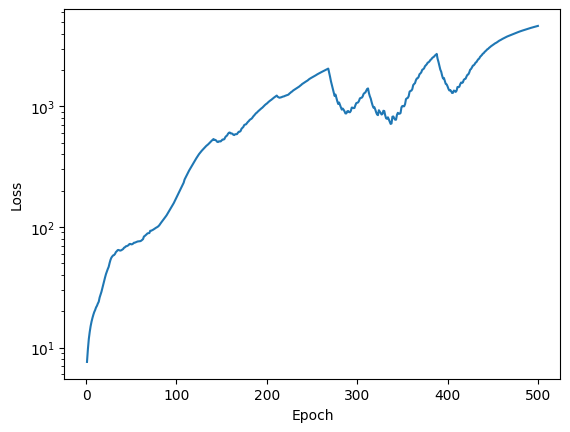

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

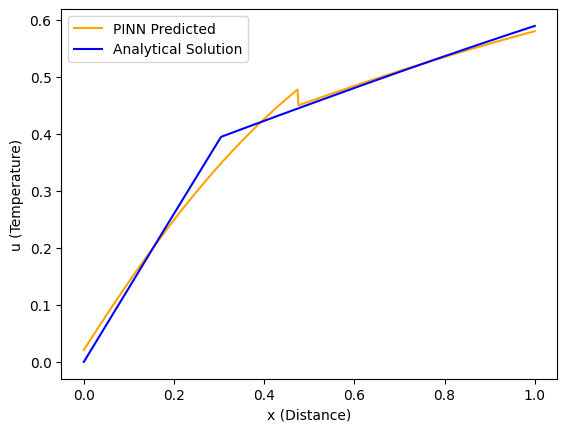

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.47572896, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

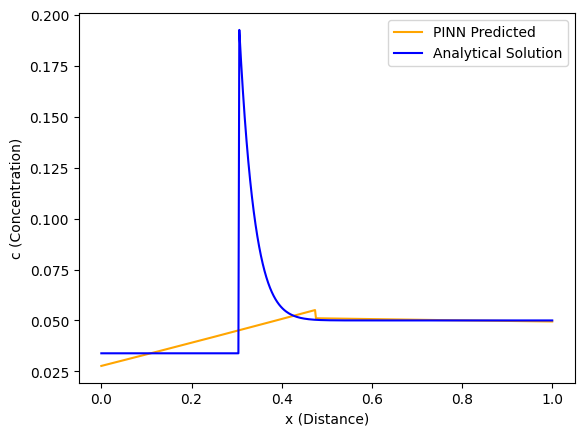

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
cmodel = c_model() # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1500,3500],[1e-2,5e-3,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.001) # Adam Optimiser

In [ ]:
def train_step(xc,lamb1,lamb2,times,e):
  # compute loss and its gradient wrt model parameters
  loss, gu, gs, gc, gur, gud, gcr, gcd = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, xc, lamb1, lamb2, times, e)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return loss, new_lamb1, new_lamb2

In [ ]:
from time import time
N = 100 # no of epochs or training iterations
losses = []
t0 = time()
epsilons = [1]#[0.01,0.1,1,10,100]
lamb1, lamb2 = 0.1, 0.1
tf.random.set_seed(0)

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        loss, lamb1, lamb2 = train_step(xc,lamb1,lamb2,times,e)
        losses.append(loss.numpy())
        if i%10 == 0:
          print('   Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 1 ...
   Epoch = 10 --> Loss = 50.671032
   Epoch = 20 --> Loss = 13.306091
   Epoch = 30 --> Loss = 6.278502
   Epoch = 40 --> Loss = 2.382527
   Epoch = 50 --> Loss = 1.2986578
   Epoch = 60 --> Loss = 0.7764933
   Epoch = 70 --> Loss = 0.4446918
   Epoch = 80 --> Loss = 0.22817165
   Epoch = 90 --> Loss = 0.59226227
   Epoch = 100 --> Loss = 0.16095248
Final Loss = 0.16095248
Computation Time = 150.2734057267507 minutes


Text(0, 0.5, 'Loss')

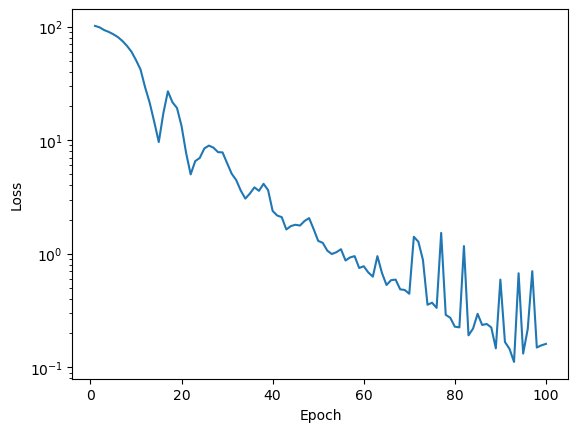

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

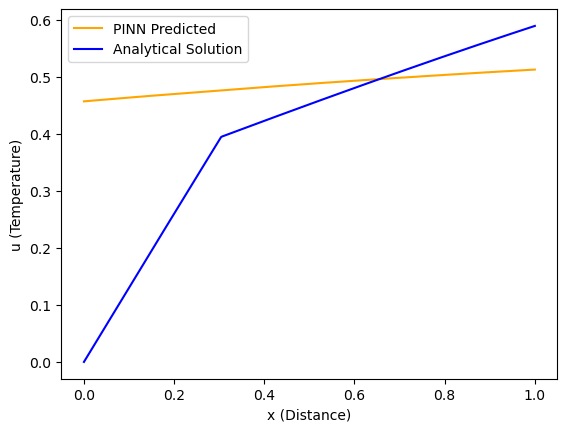

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(-0.16773708, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

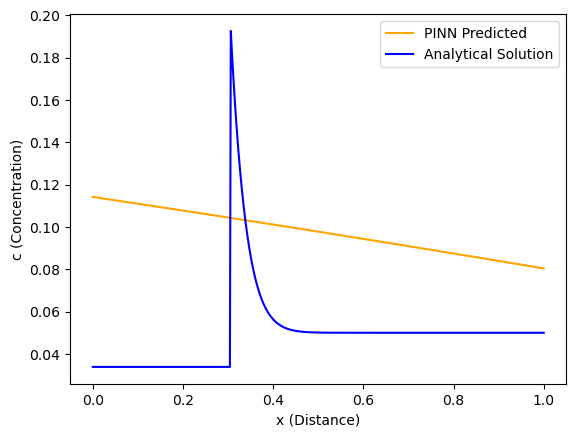

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')